In [34]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [91]:
def read_benchstat_csv(infile):
    df = pd.read_csv(infile)
    df.columns=['_name', 'time', '_time_sd']

    name_parts = df['_name'].str.extract(r'(?P<name>[^/]+)/size=(?P<size>\d+)-(?P<cpus>\d+)')
    name_parts = name_parts.astype({'size': 'int32', 'cpus': 'int32'})

    time_sd = df['_time_sd'].str.extract(r'(\d+)%', expand=False).astype('float64')
    time_sd = time_sd / 100 * df.time
    time_sd.name = 'time_sd'
    
    df = pd.concat([name_parts, df.time, time_sd], axis=1)
    return df.set_index(['name', 'size'])

In [114]:
from glob import glob
glob('./*.csv')

['./03c422e.csv', './d6683f3.csv']

In [117]:
df = read_benchstat_csv('03c422e.csv')
df

cpus        time      time_sd
name       size                                
Fork       64        8  1762680.00   52880.4000
           256       8   590528.00  342506.2400
           1024      8   457597.00  343197.7500
           4096      8   521595.00  245149.6500
           16384     8   727144.00  174514.5600
SetCursor  64        8     9044.89     180.8978
           256       8    41059.30     821.1860
           1024      8   188184.00    7527.3600
           4096      8   674742.00    6747.4200
           16384     8  3513130.00  245919.1000
InsertChar 64        8  1813050.00   90652.5000
           256       8   908054.00  127127.5600
           1024      8   920508.00  184101.6000
           4096      8  1429150.00  100040.5000
           16384     8  5224520.00  156735.6000

In [124]:
from matplotlib.ticker import EngFormatter

def plot_time_vs_size(size, time_sec, time_sd_sec):
    fig, ax = plt.subplots()
    ax.grid(True, which='both')

    # x axis configuration
    logx_min, logx_max = 5, 15
    logx_num = logx_max - logx_min + 1
    ax.set_xscale('log', basex=2)
    ax.set_xticks(np.logspace(logx_min, logx_max, num=logx_num, base=2))
    ax.set_xlabel('List size')

    # y axis configuration
    ax.set_yscale('log')
    y_formatter = EngFormatter(unit='s')
    ax.yaxis.set_minor_formatter(y_formatter)
    ax.yaxis.set_major_formatter(y_formatter)
    ax.set_ylabel('Time per operation')

    plt.errorbar(size, time_sec, fmt='o', yerr=time_sd_sec)
    return ax

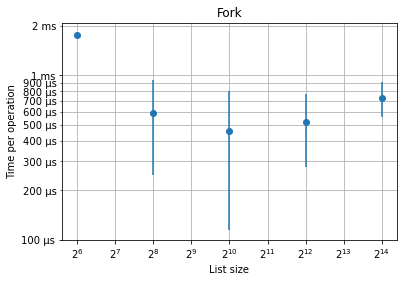

In [125]:
# Analysing fork operation
fork = df.xs('Fork')

ax = plot_time_vs_size(fork.index, fork.time * 1e-9, fork.time_sd * 1e-9)
_ = ax.set_title('Fork')

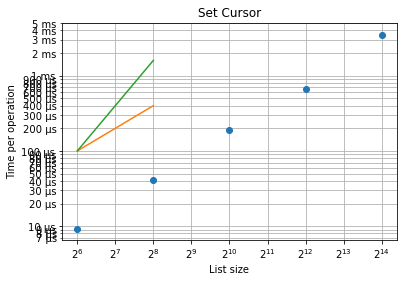

In [146]:
# Analysing set cursor operation
set_cursor = df.xs('SetCursor')

xs = set_cursor.index
ax = plot_time_vs_size(xs, set_cursor.time * 1e-9, set_cursor.time_sd * 1e-9)
ax.set_title('Set Cursor')

demo = np.logspace(6, 8, num=10, base=2)
ax.plot(demo, 100e-6 * demo/2**6)      # O(n)
ax.plot(demo, 100e-6 * (demo/2**6)**2) # O(n^2)

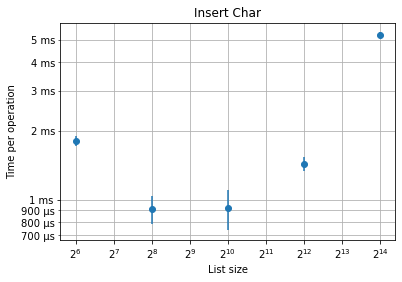

In [127]:
# Analysing insert char alone
_char = df.xs('InsertChar')

ax = plot_time_vs_size(_char.index, _char.time * 1e-9, _char.time_sd * 1e-9)
_ = ax.set_title('Insert Char')

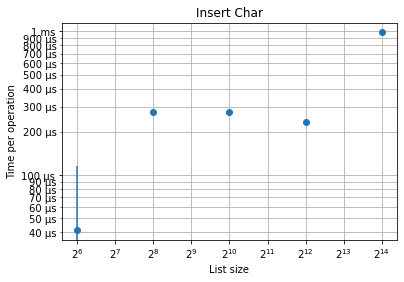

In [128]:
# Analysing insert char operation
_char = df.xs('InsertChar')

# insert_char operation is measured together with fork and set_cursor, so we need to remove their contributions.
char_time = _char.time - set_cursor.time - fork.time
char_time_sd = np.sqrt(_char.time_sd**2 - set_cursor.time_sd**2 - fork.time_sd**2)

ax = plot_time_vs_size(_char.index, char_time * 1e-9, char_time_sd * 1e-9)
_ = ax.set_title('Insert Char')